#  Conflict Impact Analysis in Middle East, North Africa, Pakistan and Afghanistan (2024)

- Geography: MENA + AP countries (MENAAP). Afghanistan, Pakistan, Algeria, Morocco, Libya, Yemen, Iran, Iraq, Syria, Egypt, Lebanon, Djibouti, United Arab Emirates, Jordan, Palestine, Oman, Qatar, Saudi Arabia, Kuwait, Tunisia, Bahrain.
- Timeline: 2024-01-01 to 2024-12-31.
- Source: ACLED conflict events; population overlays from WorldPop 2020 UN-adjusted.

**Conflict Definition**
- Only events with atleast one fatality are included in event and fatality counts.
- Excluded Peaceful protests. Included Protests when fatality threshold is met: "Protest with intervention" and "Excessive force against protesters".
- Other ACLED event types retained (subject to the fatality filter), such as: Battles; Explosions/Remote violence; Violence against civilians; Riots; Strategic developments.

**Population Data**
- Population data: WorldPop 2020 UN-adjusted population raster. Population totals are obtained by summing WorldPop 2020 populations (not official census totals), so country totals may differ from WB official figures.

**Spatial aggregation and grid size**
- Gridding scheme: Bing quadkey tiles clipped to country boundaries Quadkey Zoom Level 12 ~60–80 km²

**Exposed population definition**
"People living in the same grid tile with a cumulative ≥10 conflict fatalities during the study period"
- A tile is considered impacted if **cumulative conflict events in that tile had at least ten fatalities** during the study period.
- Exposed population is the sum of population living in impacted tiles within that country.
- Percent exposed = 100 × (exposed population) / (total population from WorldPop 2020) computed per country.

**Notes and caveats**
- Grid area varies with latitude; figures are approximate.
- Excluding "Peaceful protest" and zero-fatality events reduces counts relative to broader unrest measures.
- ACLED event geocoding precision varies; results should be interpreted with this uncertainty in mind.
- Population of countries is assumed to be static at projected 2020 values. 


In [617]:
%reload_ext autoreload
%autoreload 2

import os
import acled_conflict_analysis as acled
from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook
from bokeh.io import output_file

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel, HoverTool

from datetime import date
from datetime import datetime
import geopandas as gpd
import pandas as pd
from conflict_visuals import *

In [618]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain"]
# START_DATE1 = "2021-01-01"
# END_DATE1 = "2021-12-31"

# START_DATE2 = "2022-01-01"
# END_DATE2 = "2022-12-31"

START_DATE3 = "2024-01-01"
END_DATE3 = "2024-12-31"

In [619]:
wb_region = 'MENAAP'

In [620]:
os.environ['ACLED_EMAIL'] = extraction.get_acled_credentials()[0]
os.environ['ACLED_KEY'] = extraction.get_acled_credentials()[1]

In [621]:
# data1 = extraction.acled_api(
#     # email_address=os.environ.get("ACLED_EMAIL"),
#     # access_key=os.environ.get("ACLED_KEY"),
#     countries=countries_of_interest,
#     start_date=START_DATE1,
#     end_date=END_DATE1
# )

# data2 = extraction.acled_api(
#     countries=countries_of_interest,
#     start_date=START_DATE2,
#     end_date=END_DATE2
# )

data3 = extraction.acled_api(
    countries=countries_of_interest,
    start_date=START_DATE3,
    end_date=END_DATE3
)

data = pd.concat([data3], ignore_index=True)

🔄 Using cached OAuth token
URL: https://acleddata.com/api/acled/read
Parameters: {'_format': 'json', 'limit': 4000000, 'iso': '004|586|012|504|434|887|364|368|760|818|422|262|784|400|275|512|634|682|414|788|048', 'event_date': '2024-01-01|2024-12-31', 'event_date_where': 'BETWEEN', 'population': 'full', 'fields': 'region|country|iso|year|event_date|source|admin1|admin2|admin3|location|event_type|sub_event_type|interaction|fatalities|timestamp|latitude|longitude|actor1|actor2|notes|population_1km|population_5km|population_2km|population_best'}


/Users/ssarva/Library/CloudStorage/OneDrive-WBG/Documents/MENA-FCV-economic-monitor/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ Successfully retrieved 96123 records


In [622]:
data.drop_duplicates(inplace=True)
data.shape

(96106, 24)

In [623]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.sort_values(by='timestamp', inplace=True, ascending=False)

In [624]:
processing.data_type_conversion(data)

In [625]:
data = data[data['sub_event_type']!='Peaceful protest']
data = data[data['fatalities']>0]
data['wb_region'] = wb_region

In [626]:
extracted_date = datetime.today().strftime('%Y%m%d')

last_date = data['event_date'].max()
last_date = last_date.strftime('%d %B %Y')
extracted_date_formatted = datetime.today().strftime('%d %B %Y')

In [627]:
data.to_csv(f'../../data/conflict/acled_mena_raw_no_peaceful_protest_one_fatality{extracted_date}.csv')

## Conflict Events and Fatalities

In [628]:
start = data['event_date'].min().date()
end = data['event_date'].max().date()

In [629]:
# Report total number of conflict events after filters (no peaceful protests, fatalities > 0)
total_events = int(data.shape[0])
print(f"Total conflict events in the region (with atleast one fatality and non-peaceful protests) from {start} to {end}: {total_events:,}")

Total conflict events in the region (with atleast one fatality and non-peaceful protests) from 2024-01-01 to 2024-12-31: 12,905


In [630]:
conflict_national = processing.get_acled_by_group(data, columns=['country'], freq='YS')
conflict_national = conflict_national.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()
conflict_national.to_csv(f'../../data/conflict/acled_national_annual_one_fatality_no_peaceful_protest_{extracted_date}')

In [631]:

conflict_national.loc[conflict_national['country']=='Palestine', 'country'] = 'West Bank and Gaza'
#regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

conflict_regional_yearly = processing.get_acled_by_group(data, ['wb_region'],freq='YS')
conflict_regional_yearly.to_csv(f'../../data/acled_one_fatality_no_peaceful_protest_{wb_region}_{extracted_date}')

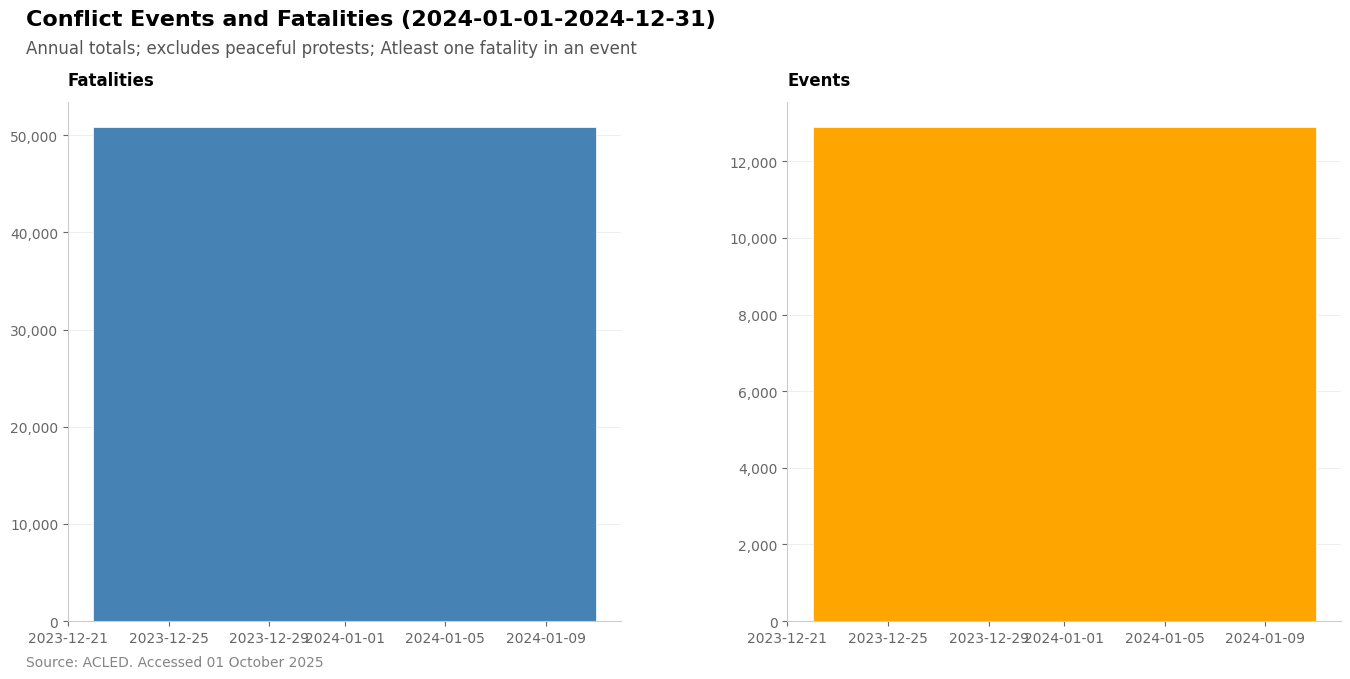

In [632]:
from conflict_visuals import plot_dual_bars_by_date

plot_dual_bars_by_date( data=conflict_regional_yearly, 
                       date_col='event_date', 
                       metrics_to_plot=['nrFatalities', 'nrEvents'], 
                       overall_title=f'Conflict Events and Fatalities ({start}-{end})', 
                       chart_subtitle='Annual totals; excludes peaceful protests; Atleast one fatality in an event', 
                       source_text=f'Source: ACLED. Accessed {extracted_date_formatted}');

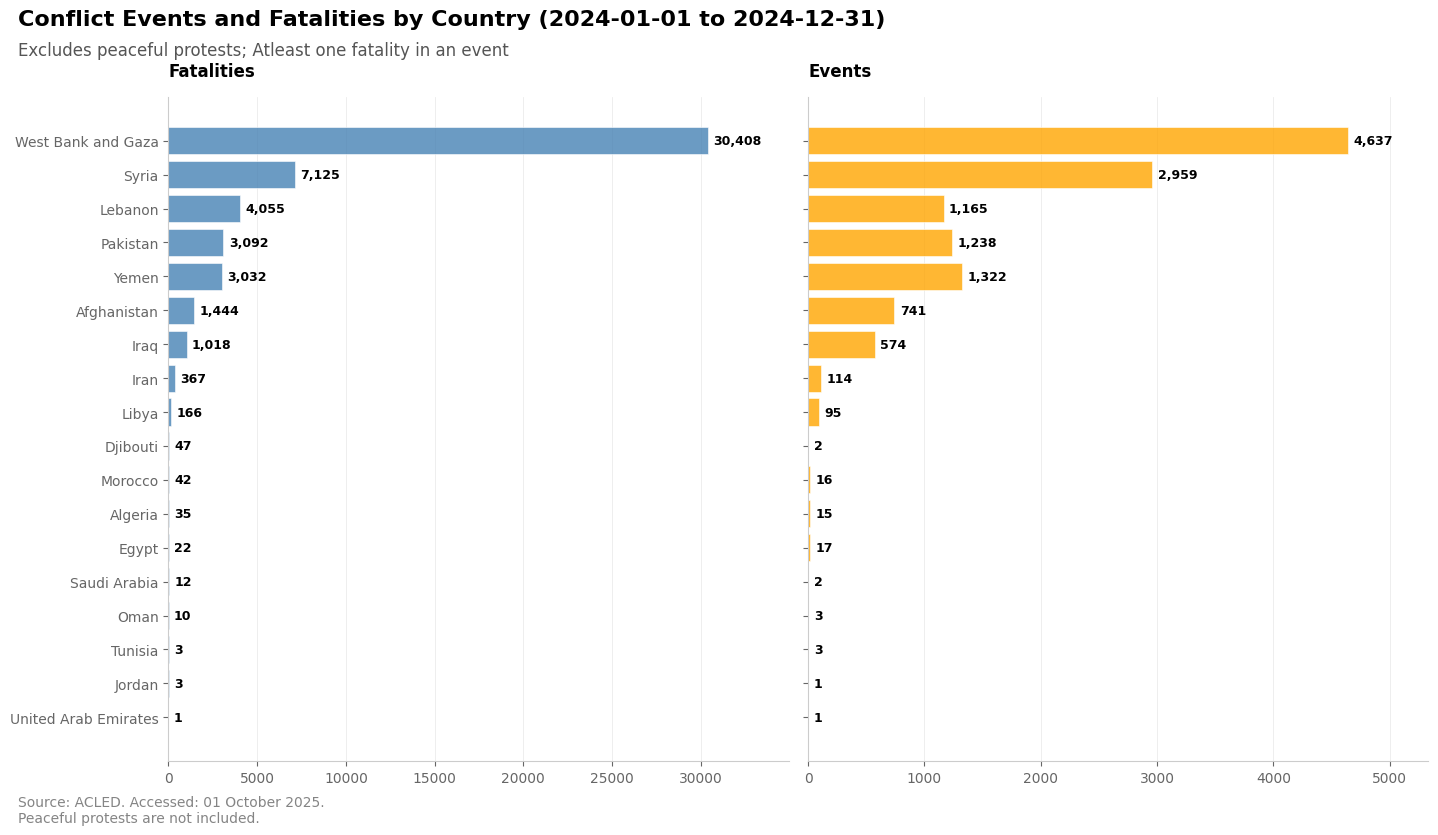

In [633]:
plot_dual_metrics_by_country(
    data =conflict_national,
    metrics_to_plot =['nrFatalities', 'nrEvents'],
    metric_display_info = {'nrFatalities': {'title': 'Fatalities', 'color': 'steelblue'},
                           'nrEvents': {'title': 'Events', 'color': 'orange'}},
    sorting_metric = 'nrFatalities',
    overall_title = f'Conflict Events and Fatalities by Country ({start} to {end})',
    chart_subtitle='Excludes peaceful protests; Atleast one fatality in an event',
    source_text = f"""Source: ACLED. Accessed: {extracted_date_formatted}.\nPeaceful protests are not included."""
);

In [634]:
from boundaries_utils import *
regional_boundary_quadkey12 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')
regional_boundary_quadkey12['country'] = regional_boundary_quadkey12['country'].apply(lambda x: get_country_name_from_iso_code(x))

regional_boundary_quadkey13 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey13.gpkg')
regional_boundary_quadkey13['country'] = regional_boundary_quadkey13['country'].apply(lambda x: get_country_name_from_iso_code(x))

In [635]:
import mercantile
def get_quadkey_from_lat_lon(lat, lon, zoom=12):
    
    tile = mercantile.tile(lon, lat, zoom)
    quadkey = mercantile.quadkey(tile)
    return quadkey

In [636]:
def get_national_conflict_at_aggregation(boundary, index_column, data):
    df = data.copy()
    #df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column, 'country'], freq='YS')
    df['index'] = df.apply(lambda row: get_quadkey_from_lat_lon(row['latitude'], row['longitude'], zoom=12), axis=1)
    df = processing.get_acled_by_group(df, columns=['index', 'country'])
    #df = df.groupby([index_column, 'country'])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column, 'country'], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

def get_national_conflict_at_aggregation_event_type(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column, 'country', 'event_type'], freq='YS')
    df = df.groupby([index_column, 'country', 'event_type'])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column, 'country'], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

def get_conflict_at_aggregation(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column], freq='YS')
    df = df.groupby([index_column])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

In [637]:
conflict_national_q12 = get_national_conflict_at_aggregation(regional_boundary_quadkey12, 'index', data)
#conflict_national_q13 = get_national_conflict_at_aggregation(regional_boundary_quadkey13, 'index', data)


In [638]:
#boundaries_quad12.reset_index().to_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')

## People living in the same grid tile (z=12) with ≥10 cumulative conflict fatalities during the study period

In [858]:
pop = gpd.read_file('../../data/population/polygons/MENAAP_pop_quad12.gpkg')
#pop_quad13 = gpd.read_file('../../data/population/polygons/MENAAP_pop_quad13.gpkg')
pop.rename(columns={'country':'country_code'}, inplace=True)
pop = pop[~(pop['country_code'].isin(['SOM', 'SDN', 'MRT']))]

In [859]:
high_fat = list(conflict_national_q12[conflict_national_q12['nrFatalities']>=10]['index'].unique())
pop[pop['index'].isin(high_fat)]['population'].sum()/1000000

np.float64(36.027781111366274)

In [641]:
from boundaries_utils import get_country_name_from_iso_code

iso_codes = pop['country_code'].unique()
country_to_iso = {get_country_name_from_iso_code(iso): iso for iso in iso_codes}
iso_to_country = {iso: get_country_name_from_iso_code(iso) for iso in iso_codes}


#iso_to_country = {iso: ('Syria' if name == 'Syrian Arab Republic' else name) for iso, name in iso_to_country.items()}
country_to_iso = {('Syrian Arab Republic' if name == 'Syria' else
                   'Iran' if name == 'Iran, Islamic Republic of' else
                   'Palestine' if name == 'Palestine, State of' else
                   name): iso for name, iso in country_to_iso.items()}

iso_to_country = {iso: ('Syria' if name == 'Syrian Arab Republic' else
                        'Iran' if name == 'Iran, Islamic Republic of' else
                        'West Bank and Gaza' if name == 'Palestine, State of' else
                        name) for iso, name in iso_to_country.items()}


In [868]:
pop_total = pd.read_csv('../../data/population/regional_total_population_2020_worldpop.csv')
pop_total.drop(columns=['Unnamed: 0'], inplace=True)
pop_total.rename(columns={'iso3': 'country_code'}, inplace=True)
pop_total_dict = pop_total.set_index('country_code').to_dict()['totalPopulation']

In [861]:
wb_regions = pd.read_csv('../../data/worldbank_regions_iso3_exclusions.csv')
wb_regions.drop(columns=['Unnamed: 0'], inplace=True)

In [875]:
conflict_national_q12_10f = conflict_national_q12[conflict_national_q12['nrFatalities']>=10]

impacted_quad12_no_merge = pd.DataFrame()

idxs = conflict_national_q12_10f['index'].unique()
impacted_quad12_no_merge = pop[(pop['index'].isin(idxs))][['country_code', 'population']]


region_code_name_mapping = wb_regions[['region_code', 'region_name']].drop_duplicates().set_index(['region_code']).to_dict()['region_name']
country_code_mapping = wb_regions[['country_code', 'country_name']].drop_duplicates().set_index(['country_code']).to_dict()['country_name']

impacted_quad12_no_merge['country'] = impacted_quad12_no_merge['country_code'].map(country_code_mapping)
#impacted_quad12_no_merge['region'] = impacted_quad12_no_merge['region_code'].map(region_code_name_mapping)
 
impacted_quad12_no_merge = impacted_quad12_no_merge.groupby(['country', 'country_code'])[['population']].sum().reset_index()
impacted_quad12_no_merge['totalPopulation'] = impacted_quad12_no_merge['country_code'].map(pop_total_dict)

impacted_quad12_no_merge['pc_population'] = 100*impacted_quad12_no_merge['population']/impacted_quad12_no_merge['totalPopulation']

In [910]:
impacted_quad12 = conflict_national_q12_10f.merge(pop[['index', 'population']], on =['index'], how='inner')
impacted_quad12 = impacted_quad12.groupby(['country', 'country_code'])['population'].sum().reset_index()
impacted_quad12['totalPopulation'] = impacted_quad12['country_code'].map(pop_total_dict)
impacted_quad12['pc_population'] = 100*impacted_quad12['population']/impacted_quad12['totalPopulation']

### People living in the same 60–80 sqkm grid tile (z=12) with ≥10 cumulative conflict fatalities

In [911]:
pc_total_pop = np.round(100*impacted_quad12_no_merge['population'].sum()/pop_total['totalPopulation'].sum(),2)
print(f'{np.round(impacted_quad12['population'].sum()/1000000,5)} million people living in the same area (60-80sqkm) as a conflict event in 2024 in MENAAP. \nThis is {pc_total_pop}% of the total population.')

36.02778 million people living in the same area (60-80sqkm) as a conflict event in 2024 in MENAAP. 
This is 5.04% of the total population.


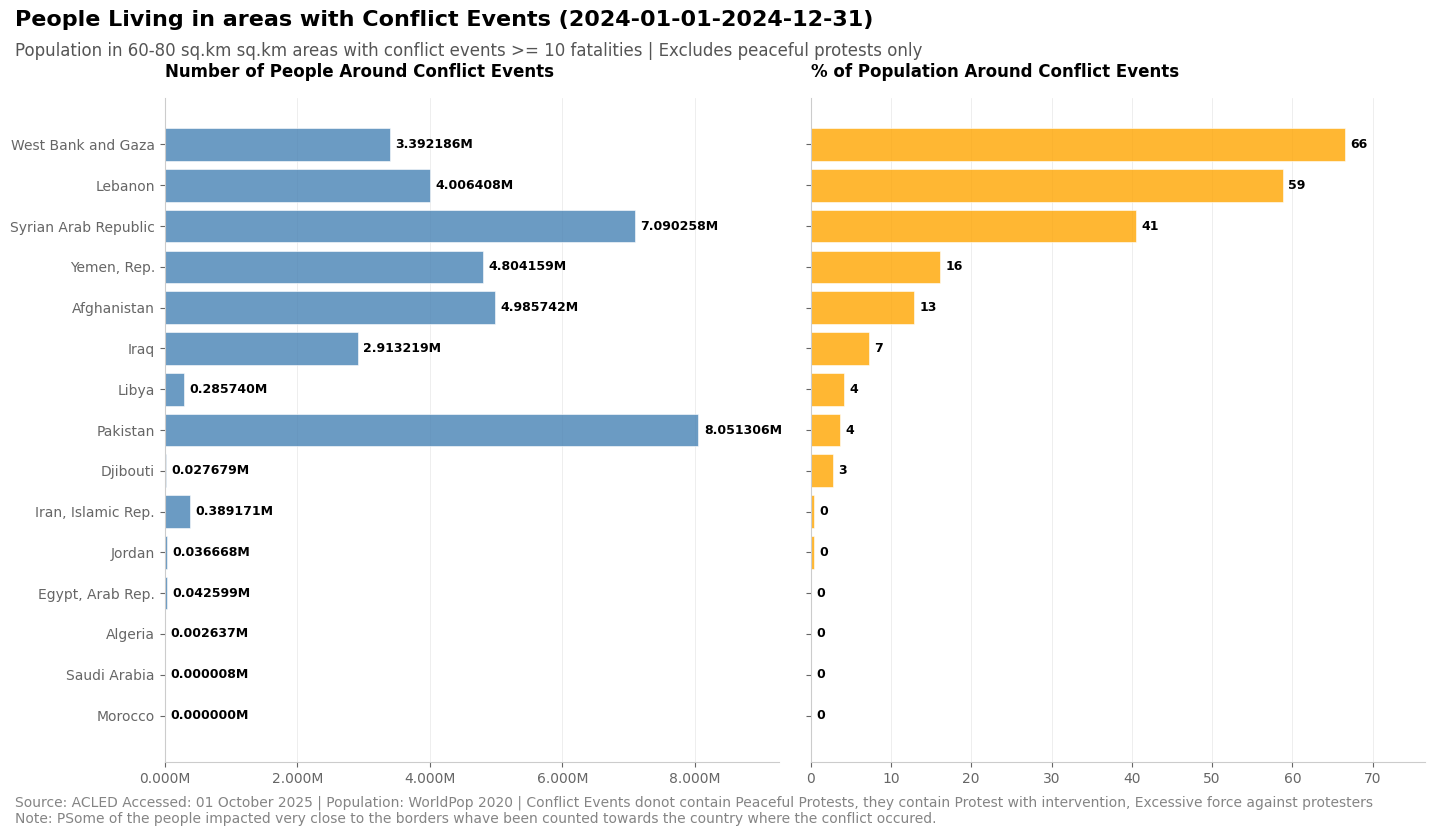

In [914]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =impacted_quad12_no_merge,
    metrics_to_plot =['population', 'pc_population'],
    metric_display_info = {'population': {'title': 'Number of People Around Conflict Events', 'color': 'steelblue'},
                           'pc_population': {'title': '% of Population Around Conflict Events', 'color': 'orange'}},
    sorting_metric = 'pc_population',
    overall_title = f'People Living in areas with Conflict Events ({start}-{end})',
    chart_subtitle='Population in 60-80 sq.km sq.km areas with conflict events >= 10 fatalities | Excludes peaceful protests only',
    source_text = f'Source: ACLED Accessed: {extracted_date_formatted} | Population: WorldPop 2020 | Conflict Events donot contain Peaceful Protests, they contain Protest with intervention, Excessive force against protesters\nNote: PSome of the people impacted very close to the borders whave been counted towards the country where the conflict occured.',
    #millions_separator=False
);

In [915]:
impacted_quad12_no_merge.to_csv(f'../../data/conflict/chart_raw_data/population_by_conflict_quad12_10f_menaap_{extracted_date}.csv')